<a href="https://colab.research.google.com/github/alexkardan/ABS-Visualizations/blob/main/ABS_High_Volume_Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

## **About Dataset**
#This dataset originates from Alcohol Beverage Services (ABS) in Montgomery County, Maryland. This is for the low volume store located on Rockville Pike; Revenue for the entire store between $6-8m and there is 2 delivery per week for restocking alcohol items

#This includes the top 500 sales by quantity for the entire calendar year of 2024. It includes columns like Item ID, Description, Bottles Per Case,

#Cost Amount (Per Bottle). This data is separated into 52 weeks of quantity sold data for every single one of these top 500 items

# **Goals**

#Calculate the minimum shelf stock and re-order Amount for ABS's ordering system to maintain enough stock in store of items to adequately serve their customers while reducing slow-moving inventory in stores. Reorder point being the stock level at which a new order should be placed. With minimum shelf stock being how much of an item should there be at all times.

#This analysis will also account for seasonal demand shifts for instance, how certain alcohol types gain or lose popularity from winter to spring.

In [241]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px

In [242]:
Weekly_High_Volume_Store = pd.read_csv("Montgomery College Data Set (High Volume_Weekly).csv", header = 1)

The dataset is loaded from a CSV file with header=1 specified to ensure the 52 weeks of quantity sold columns are properly labeled with week numbers.

#**EDA**

In [243]:
Weekly_High_Volume_Store.describe()

,ItemID,Bottles Per Case,Cost Amount (Per Bottle),1,2,3,4,5,6,7,...,45,46,47,48,49,50,51,52,53,Grand Total
count,500.000000,500.0000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,85910.848000,34.6960,10.092725,11.618000,16.142000,16.142000,17.23600,17.080000,19.042000,18.950000,...,21.276000,20.854000,20.768000,26.79800,18.660000,21.938000,25.740000,24.646000,13.112000,1109.800000
std,86109.652048,36.8061,13.193010,20.235588,21.948058,21.948058,25.31644,25.205957,27.851888,28.265055,...,31.463435,31.603009,29.908313,39.48391,26.748371,33.428387,39.326092,36.093631,22.671556,1261.979884
min,1880.000000,6.0000,0.732667,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000
25%,30963.750000,12.0000,1.831667,0.000000,1.750000,1.750000,3.00000,1.000000,4.000000,3.000000,...,2.750000,2.000000,4.000000,5.00000,0.000000,2.000000,3.000000,0.000000,0.000000,473.500000
50%,61887.000000,24.0000,2.990000,6.000000,10.000000,10.000000,11.00000,10.000000,12.000000,11.000000,...,12.000000,12.000000,12.000000,15.50000,10.000000,12.000000,15.000000,14.500000,6.000000,711.500000
75%,88589.250000,24.0000,13.990000,13.000000,20.000000,20.000000,22.00000,20.000000,23.000000,24.000000,...,24.000000,24.000000,24.000000,31.00000,23.250000,24.250000,29.000000,28.000000,14.000000,1190.000000
max,431575.000000,126.0000,73.990000,230.000000,181.000000,181.000000,280.00000,210.000000,240.000000,252.000000,...,211.000000,204.000000,216.000000,294.00000,184.000000,290.000000,420.000000,270.000000,211.000000,7690.000000


In [244]:
Weekly_High_Volume_Store.tail()

,ItemID,Description,Bottles Per Case,Cost Amount (Per Bottle),1,2,3,4,5,6,...,45,46,47,48,49,50,51,52,53,Grand Total
495,18798,TRULY VODKA SELTZER VARIETY 3/8 CANS,24,2.37375,8,8,8,8,16,0,...,0,8,0,0,16,16,0,0,0,394
496,297232,POST MERIDIEM SOUTHSIDE 24/100ML,24,4.99000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29
497,83305,K JACKSON VINT RES S/BLC - 750ML,12,14.99000,0,2,2,5,7,4,...,5,1,5,3,9,18,21,12,6,382
498,36722,KETEL ONE VODKA - 750ML,12,27.99000,2,8,8,5,5,7,...,2,13,4,9,5,11,10,13,6,399
499,330401,JOSH CELLARS S/BLC - 750ML,12,16.99000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29


In [245]:
Weekly_High_Volume_Store = Weekly_High_Volume_Store.loc[:, ~Weekly_High_Volume_Store.columns.str.contains("^Unnamed")]

Removed any columns starting with 'Unamed' and helps to label each column header with week 1, week 2 etc.

In [246]:
grand_total_column = Weekly_High_Volume_Store.iloc[:, -1]

Weekly_High_Volume_Store = Weekly_High_Volume_Store.iloc[:, :-1]

new_columns = ["Item ID", "Description", "Bottles Per Case", "Cost Amount (Per Bottle)"]

num_weeks = len(Weekly_High_Volume_Store.columns) - len(new_columns)
week_columns = [f"Week {i+1}" for i in range(num_weeks)]

final_columns = new_columns + week_columns

Weekly_High_Volume_Store.columns = final_columns

Weekly_High_Volume_Store = pd.concat([Weekly_High_Volume_Store, grand_total_column], axis=1)

Weekly_High_Volume_Store.columns = list(Weekly_High_Volume_Store.columns[:-1]) + ['Grand Total']

print(Weekly_High_Volume_Store.head())
print(Weekly_High_Volume_Store.columns)

   Item ID                           Description  Bottles Per Case  \
0    18467                   SCOTTY'S VODKA 50ML                96   
1    96741            CORONA EXTRA 4/6 NR - 12OZ                24   
2    70417  FIREBALL CINN WHISKY 50ML/10PK LOOSE               120   
3   249230       FIREBALL WHISKY 10PK SLV - 50ML               120   
4    35211                 SMIRNOFF VODKA - 50ML               120   

   Cost Amount (Per Bottle)  Week 1  Week 2  Week 3  Week 4  Week 5  Week 6  \
0                  0.990000      60      93      93      94      89     114   
1                  1.831667     162       0       0     144     144     132   
2                  1.090000      62     170     170     108     166     141   
3                  1.090000     230     100     100     280     210     240   
4                  0.990000     142     181     181     154     167     224   

   ...  Week 45  Week 46  Week 47  Week 48  Week 49  Week 50  Week 51  \
0  ...      164      170      1

#**Weekly Sales Grouped**
#1. Weekly sales columns have been relabeled with clear headers ('Week 1' through 'Week 53') for improved readability and being much easier to do visualizations with

#2. The first four columns  'Item ID', 'Description', 'Bottles Per Case', and 'Cost Amount (Per Bottle)'  are preserved as potential columns of use.

#3. Although the dataset includes 53 weeks, the first and last weeks are partial (less than 7 days each), representing a full year (365 days) of sales data distributed across 52 effective weeks.

In [247]:
quarterly_mapping = {
    'Q1': [f'Week {i}' for i in range(1, 13)],
    'Q2': [f'Week {i}' for i in range(14, 27)],
    'Q3': [f'Week {i}' for i in range(28, 40)],
    'Q4': [f'Week {i}' for i in range(41, 53)]
}

week_to_quarter = {week: quarter for quarter, weeks in quarterly_mapping.items() for week in weeks}

week_columns = [f'Week {i}' for i in range(1, 54)]


melted_Weekly_High_Volume_Store = Weekly_High_Volume_Store.melt(
    id_vars=["Item ID", "Description", "Bottles Per Case", "Cost Amount (Per Bottle)"],
    value_vars=week_columns,
    var_name="Week",
    value_name="Quantity"
)






# **Quarterly Grouping of Weekly Sales Data**
#   - Q1: Weeks 1–13
#   - Q2: Weeks 14–26
#   - Q3: Weeks 27–39
#   - Q4: Weeks 40–53
# Created a mapping dictionary to associate each week with its corresponding quarter.

# Transformed (melted) the dataset from wide to long format:
#   - 'Week 1' to 'Week 52' columns are unpivoted into a single 'Week' column
#   - Corresponding quantities are stored in a new 'Quantity' column
#   - Retains item metadata columns: 'Item ID', 'Description', 'Bottles Per Case', and 'Cost Amount (Per Bottle)'

# This structure simplifies seasonal and time-series analysis by aligning data with quarterly trends.

In [248]:
Weekly_High_Volume_Store.columns

Index(['Item ID', 'Description', 'Bottles Per Case',
       'Cost Amount (Per Bottle)', 'Week 1', 'Week 2', 'Week 3', 'Week 4',
       'Week 5', 'Week 6', 'Week 7', 'Week 8', 'Week 9', 'Week 10', 'Week 11',
       'Week 12', 'Week 13', 'Week 14', 'Week 15', 'Week 16', 'Week 17',
       'Week 18', 'Week 19', 'Week 20', 'Week 21', 'Week 22', 'Week 23',
       'Week 24', 'Week 25', 'Week 26', 'Week 27', 'Week 28', 'Week 29',
       'Week 30', 'Week 31', 'Week 32', 'Week 33', 'Week 34', 'Week 35',
       'Week 36', 'Week 37', 'Week 38', 'Week 39', 'Week 40', 'Week 41',
       'Week 42', 'Week 43', 'Week 44', 'Week 45', 'Week 46', 'Week 47',
       'Week 48', 'Week 49', 'Week 50', 'Week 51', 'Week 52', 'Week 53',
       'Grand Total'],
      dtype='object')

Checking to make sure all of the column headings are correct

In [249]:
def items(description):
    description = description.upper()

    if any(keyword in description for keyword in [
        'WHISKEY', 'WHISKY', 'JACK DANIELS', 'JAMESON', 'CROWN ROYAL', 'FIREBALL',
        'MAKER\'S MARK', 'WILD TURKEY', 'BULLEIT', 'KNOB CREEK', 'WOODFORD RESERVE',
        'BASIL HAYDEN', 'EVAN WILLIAMS', 'BLACK VELVET', 'SEAGRAMS 7', 'REBEL YELL',
        'BUFFALO TRACE', 'ELIJAH CRAIG', 'GEORGE DICKEL', 'OLD FORESTER', 'RITTENHOUSE',
        'TINCUP', 'HIGH WEST', 'FOUR ROSES', '1792', 'OLD GRAND-DAD', 'LARCENY', 'TEMPLETON',
        'MICHter\'S', 'WELLER', 'WIDOW JANE', 'PENDLETON', 'JEFFERSON\'S', 'HUDSON',
        'WOLF SPIRIT', 'WESTWARD', 'NEW RIFF', 'PEERLESS', 'STRANAHAN\'S'
    ]):
        return 'Whiskey'

    elif any(keyword in description for keyword in [
    'VODKA', 'TITO', 'SMIRNOFF', 'GREY GOOSE', 'ABSOLUT', 'NEW AMSTERDAM', 'CIROC',
    'SKYY', 'STOLI', 'BELVEDERE', 'KETEL ONE', 'SCOTTY\'S', 'SVEDKA', 'UV', 'PEARL',
    'ZUBROWKA', 'LUKSUSOWA', 'REYKA', 'RAIN', 'CHOPIN', 'THREE OLIVES', 'WHEATLEY',
    'RUSSIAN STANDARD', 'BLUE ICE', 'NIKOLAI', '360 VODKA', 'PRAVDA', 'JEWEL OF RUSSIA',
    # Added Gin terms here:
    'GIN', 'BOMBAY', 'TANQUERAY', 'HENDRICK', 'BEEFEATER', 'PLYMOUTH', 'AVIATION',
    'MONKEY 47', 'SEAGRAM\'S', 'NOLET\'S', 'THE BOTANIST', 'EMPRESS', 'BARR HILL',
    'BROKER\'S', 'BULLDOG', 'SIPSMITH', 'DRY GIN', 'LONDON DRY', 'OLD TOM GIN'
]):
      return 'Vodka / Gin'


    elif any(keyword in description for keyword in [
        'TEQUILA', 'PATRON', 'JOSE CUERVO', 'DON JULIO', 'CASAMIGOS', 'EL JIMADOR',
        'HORNITOS', 'ESPOLON', 'TEREMANA', 'MILAGRO', 'CAMARENA', 'AVION',
        'CAZADORES', 'CLASE AZUL', 'FORTALEZA', 'OLMECA', 'TRES GENERACIONES',
        '1800', 'MI CAMPO', 'MONTELOBOS', 'MAESTRO DOBEL', 'DELEON', 'VOLCAN', 'SANTO',
        'HERRADURA', 'TIERRA NOBLE', 'SIETE LEGUAS', 'LOS AZULEJOS', 'DULCE VIDA'
    ]):
        return 'Tequila'

    elif any(keyword in description for keyword in [
        'RUM', 'BACARDI', 'CAPTAIN MORGAN', 'MALIBU', 'CRUZAN', 'MYERS', 'SAILOR JERRY',
        'ZACAPA', 'PUSSER\'S', 'PLANTATION', 'RON DEL BARRILITO', 'MOUNT GAY',
        'HAVANA CLUB', 'PARROT BAY', 'BRUGAL', 'APPLETON', 'FLOR DE CAÑA', 'DON Q',
        'KRAKEN', 'GOSLINGS', 'BOUNTY', 'TEN TO ONE', 'RHUM', 'ST JAMES', 'EL DORADO'
    ]):
        return 'Rum'

    elif any(keyword in description for keyword in [
        'CORONA', 'MODELO', 'HEINEKEN', 'GUINNESS', 'BUDWEISER', 'COORS', 'STELLA',
        'MICHELOB', 'BLUE MOON', 'YUENGLING', 'BUSCH', 'MILLER', 'ANGRY ORCHARD',
        'DOS EQUIS', 'PACIFICO', 'SAM ADAMS', 'SHINER', 'ROLLING ROCK', 'NATTY BOH',
        'PABST', 'FOSTERS', 'RED STRIPE', 'KIRIN', 'ASAHI', 'CARLSBERG', 'BECK\'S',
        'BEER', 'IPA', 'LAGER', 'ALE', 'STOUT', 'PORTER', 'PILSNER', 'DRAFT', 'PALE ALE',
        'KONA', 'LEINENKUGEL', 'VICTORY', 'NEW BELGIUM', 'SIERRA NEVADA', 'FOUNDERS',
        'GOLDEN ROAD', 'VOODOO RANGER', 'TERRAPIN', 'DOGFISH HEAD', 'BALLAST POINT',
        'FAT TIRE', 'BELL\'S', '21ST AMENDMENT', 'BREWDOG', 'CIGAR CITY'
    ]):
        return 'Beer'

    elif any(keyword in description for keyword in [
        'WINE', 'MERLOT', 'CABERNET', 'CHARDONNAY', 'PINOT', 'RIESLING', 'MOSCATO',
        'ZINFANDEL', 'SAUVIGNON', 'ROSE', 'SYRAH', 'MALBEC', 'BOTA BOX', 'BAREFOOT',
        'YELLOWTAIL', 'BLACK BOX', 'WOODBRIDGE', 'APOTHIC', 'MENAGE A TROIS', 'STELLA ROSA',
        'KENDALL JACKSON', 'JOSH CELLARS', 'CUPCAKE', 'LA CREMA', 'MEIOMI', '14 HANDS',
        'DECOY', 'RAVENSWOOD', 'DUCKHORN', 'CHARLES SMITH', 'CAVIT', 'SANTA MARGHERITA',
        'EDNA VALLEY', 'CLOS DU BOIS', 'ROBERT MONDAVI', 'J LOHR', 'LOUIS MARTINI'
    ]):
        return 'Wine'

    elif any(keyword in description for keyword in [
        'CHAMPAGNE', 'PROSECCO', 'SPARKLING', 'BRUT', 'MOET', 'VEUVE', 'BAREFOOT BUBBLY',
        'MUMM', 'LA MARCA', 'ROEDERER', 'TOTT\'S', 'CHANDON', 'ANDRE', 'DOM PERIGNON',
        'FREIXENET', 'KORBEL', 'COOK\'S', 'BELLAFINA', 'POMMERY', 'BOIZEL', 'PIPER HEIDSIECK'
    ]):
        return 'Sparkling Wine'

    elif any(keyword in description for keyword in [
        'LIQUEUR', 'BAILEYS', 'KAHLUA', 'AMARETTO', 'GRAND MARNIER', 'SOUTHERN COMFORT',
        'SCHNAPPS', 'RUMCHATA', 'FRANGELICO', 'SAMBUCA', 'JAGERMEISTER', 'DRAMBUIE',
        'MIDORI', 'GALLIANO', 'TUACA', 'GODIVA', 'CHAMBORD', 'COINTREAU',
        'CREME DE MENTHE', 'BLUE CURACAO', 'GOLDSCHLAGER', 'TRIPLE SEC', 'PAMA',
        'DISARONNO', 'IRISH CREAM', 'MALIBU BLACK', 'PEACH SCHNAPPS', 'BUTTERSHOTS'
    ]):
        return 'Liqueur'

    elif any(keyword in description for keyword in [
        'BRANDY', 'COGNAC', 'HENNESSY', 'REMY MARTIN', 'COURVOISIER', 'E&J', 'D\'USSE',
        'TORRES', 'HINE', 'CAMUS', 'ST-RÉMY', 'PAUL MASSON', 'MARTELL', 'BARON OTARD',
        'LOUIS XIII', 'VSOP', 'XO', 'GRANDE CHAMPAGNE', 'ARMAGNAC'
    ]):
        return 'Brandy / Cognac'

    elif any(keyword in description for keyword in [
        'SELTZER', 'TRULY', 'WHITE CLAW', 'VIZZY', 'HIGH NOON', 'PRESS', 'BUBLY',
        'BON VIV', 'CANTEEN', 'NÜTRL', 'CANTINA', 'TOPO CHICO', 'SMIRNOFF SELTZER',
        'NATURAL LIGHT SELTZER', 'BUD LIGHT SELTZER', 'RANCH WATER', 'SONIC HARD SELTZER',
        'DEEP EDDY SELTZER', 'POWDER SELTZER', 'CANTEEN VODKA SODA', 'VIVE', 'HAPPY DAD',
        'KONA SELTZER', 'TRULY VODKA', 'FISHER\'S ISLAND', 'OHZA', 'VIVA'
    ]):
        return 'Hard Seltzer'

# **Categorizing Alcohol Types**

# Converting the product description to uppercase to ensure case-insensitive matching.
# Categories include:
# - Whiskey
# - Vodka / Gin
# - Tequila
# - Rum
# - Beer
# - Wine
# - Sparkling Wine (Champagne/Prosecco)
# - Liqueur
# - Brandy / Cognac
# - Hard Seltzer

# The function checks each description against a curated list of brand names and keywords for each category.
# If a keyword match is found, the corresponding category label is returned.
# This classification improves data analysis by grouping products under standardized types.

In [250]:
Weekly_High_Volume_Store['Description'] = Weekly_High_Volume_Store['Description'].apply(items)

Applying the alcohol type classification to the 'Description' column in the dataset

In [251]:
melted_sales_data = Weekly_High_Volume_Store.melt(id_vars=['Item ID', 'Description', 'Bottles Per Case'],
                                                         value_vars= week_columns,
                                                         var_name='Week', value_name='Quantity Total')

melted_sales_data['Quarter'] = melted_sales_data['Week'].map(week_to_quarter)




- Reshaped the dataset so each row represents an item’s total weekly sales.

- Retained 'Item ID', 'Description', and 'Bottles Per Case' as key variables of interest.

- Mapped each week to its corresponding quarter to enable seasonal trend analysis.

<ipython-input-252-c7c39afc6174>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Quarter', y = 'Quantity Total', data = melted_sales_data, palette = color, estimator = sum, errorbar = None)


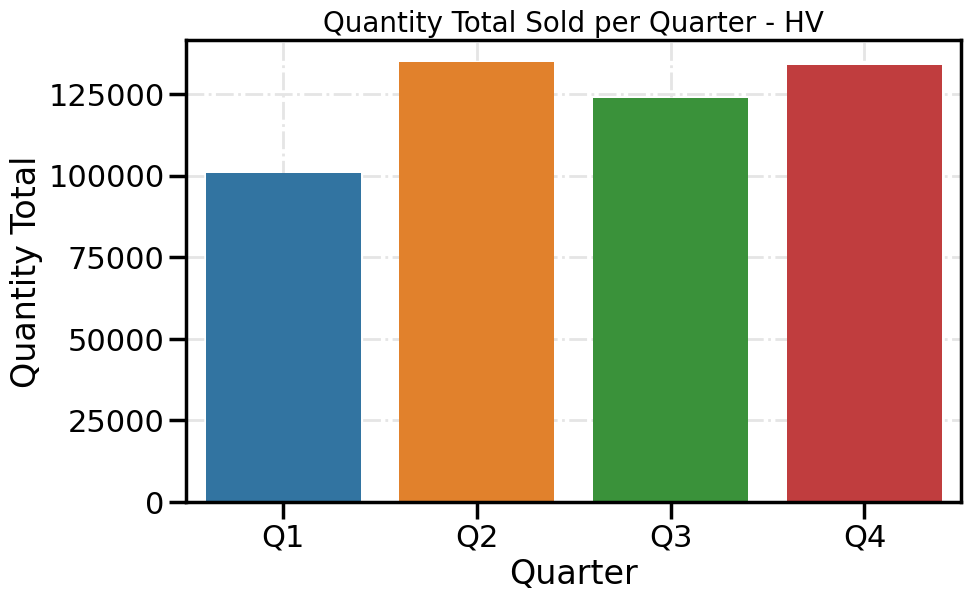

In [252]:
plt.figure(figsize = (10,6))
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
quarterly_sales = melted_sales_data.groupby(['Description', 'Quarter'])['Quantity Total'].sum().reset_index()
sns.barplot(x = 'Quarter', y = 'Quantity Total', data = melted_sales_data, palette = color, estimator = sum, errorbar = None)
plt.title("Quantity Total Sold per Quarter - HV", fontsize=20)
plt.grid(True, linestyle = '-.', color = '#e5e5e5')
plt.gca().set_axisbelow(True)
plt.show()

#**Quantity Sold per Quarter Bar chart**

- Created a bar plot showing total quantity sold per quarter using Seaborn, grouped by item descriptions.

- Applied custom colors and disabled error bars for a cleaner visual.

- Added a grid and set axis to improve readability of the chart.

In [253]:


weekly_totals = (
    melted_sales_data
    .groupby(['Week', 'Quarter', 'Description'], as_index=False)
    .agg({'Quantity Total': 'mean', 'Bottles Per Case': 'median'})
)

weekly_stats = (
    weekly_totals
    .groupby(['Quarter', 'Description'])[['Quantity Total', 'Bottles Per Case']]
    .agg(['mean', 'std'])
    .reset_index()
)

estimates = {
    'Corona': 374,
    'Vodka': 72,
    'Tequila': 35,
    'Beer': 12,
    'Whiskey': 7}

weekly_stats.columns = [
    f"{col[0]}_{col[1]}" if col[1] else col[0] for col in weekly_stats.columns
]

weekly_stats['Lead Time'] = weekly_stats['Description'].apply(lambda x: 14 if x == 'Beer' else 10)
weekly_stats['Daily Avg Sales'] = weekly_stats['Quantity Total_mean'] / 7
safety_multiplier = 2

weekly_stats['Reorder Point'] = (
    (weekly_stats['Daily Avg Sales'] * weekly_stats['Lead Time']) +
    (safety_multiplier * weekly_stats['Quantity Total_mean'])
)

weekly_stats.rename(columns={
    'Quantity Total_mean': 'Weekly Avg',
    'Quantity Total_std': 'Weekly Std Dev',
    'Bottles Per Case_mean': 'median Bottles/Case',
    'Bottles Per Case_std': 'Std Bottles/Case',
    'Description': 'Alcohol Type',
    'Daily Avg Sales': 'Daily Avg'
}, inplace=True)

buffer_zone = 1.65

lead_time = 10
weekly_stats['Lead Time'] = lead_time

weekly_stats['Reorder Threshold'] = weekly_stats['Alcohol Type'].apply(lambda x: 14 if x == 'Beer' else 10)

weekly_stats['Daily Std Dev'] = weekly_stats['Weekly Std Dev'] / (7 ** 0.5)

weekly_stats['Safety Stock'] = buffer_zone * weekly_stats['Daily Std Dev'] * (weekly_stats['Lead Time'] ** 0.5)

weekly_stats['Reorder Point'] = (
    weekly_stats['Daily Avg'] * weekly_stats['Lead Time']
) + weekly_stats['Safety Stock']
print(weekly_stats)


   Quarter     Alcohol Type  Weekly Avg  Weekly Std Dev  median Bottles/Case  \
0       Q1             Beer   18.168699        4.349792                 24.0   
1       Q1  Brandy / Cognac    9.370370        2.679403                 24.0   
2       Q1     Hard Seltzer   25.277778        5.363444                 24.0   
3       Q1          Liqueur   17.702778        2.651451                120.0   
4       Q1              Rum   13.015152        2.309808                 24.0   
5       Q1   Sparkling Wine   13.125000        9.326059                 18.0   
6       Q1          Tequila   11.478070        2.173327                 12.0   
7       Q1      Vodka / Gin   19.986842        2.465088                 24.0   
8       Q1          Whiskey   23.689394        2.288260                 24.0   
9       Q1             Wine    9.886905        1.516058                 12.0   
10      Q2             Beer   23.842402        1.876910                 24.0   
11      Q2  Brandy / Cognac    9.470085 

# **ABS Algorithim**

1. First grouped sales by Week, Quarter, and Description to get average weekly sales and median bottles per case.

2. Then grouped again by Quarter and Description to calculate mean and standard deviation for both sales and bottles per case.

3. Cleaned up column names to make them easier to read, and added lead times14 days for beer, 10 for everything else.

4. Calculated daily averages and daily standard deviations, then used a buffer zone of 1.65 to compute safety stock.

5. Finally, updated the Reorder Point formula to include safety stock for a more accurate threshold based on demand variability and lead time.

This allows for visualizations to more easily be done by utilizing several variables like quarter, alcohol type, safety stock and reorder point.

In [254]:
weekly_stats['Reorder Point ABS'] = weekly_stats['Daily Avg'] * weekly_stats['Lead Time'] / 2.6


ABS calculates their reorder point using daily average sales multiplied by lead time. Since my current calculations are based on a quarterly (13-week) basis and ABS uses a 5-week timeframe, I divided the result by 2.6 (13 ÷ 5) to align my formula with ABS’s 5-week reorder point approach.

In [255]:
weekly_stats.columns

Index(['Quarter', 'Alcohol Type', 'Weekly Avg', 'Weekly Std Dev',
       'median Bottles/Case', 'Std Bottles/Case', 'Lead Time', 'Daily Avg',
       'Reorder Point', 'Reorder Threshold', 'Daily Std Dev', 'Safety Stock',
       'Reorder Point ABS'],
      dtype='object')

updated version with the new column added of 'Reorder Point ABS'

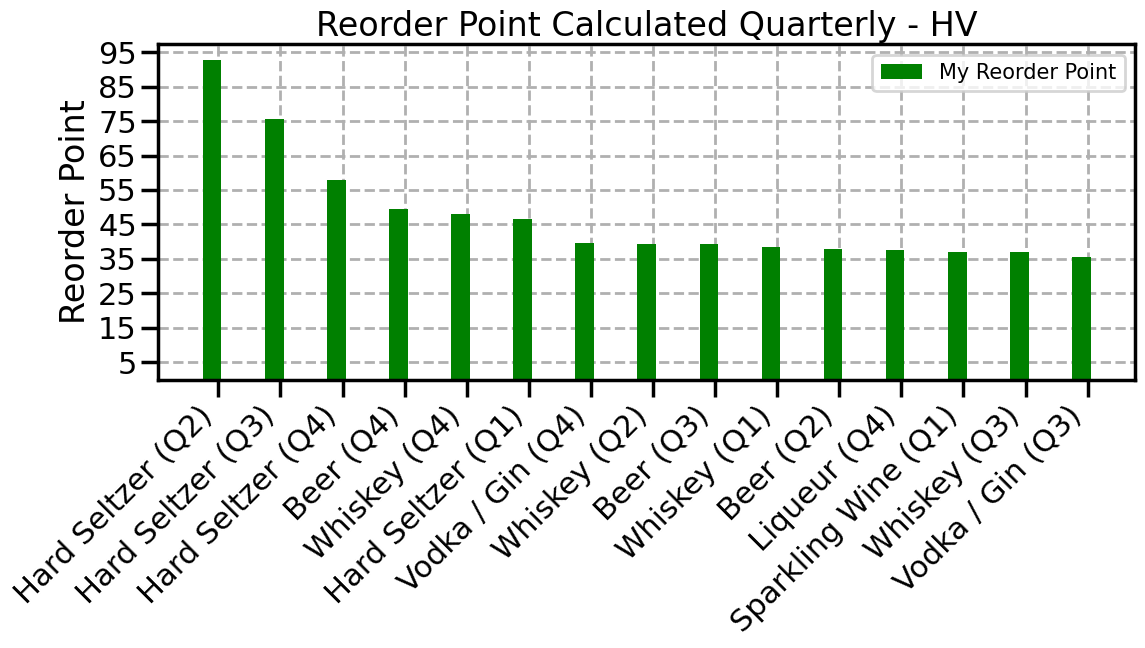

In [256]:
subset = weekly_stats[['Alcohol Type', 'Reorder Point', 'Reorder Point ABS', 'Quarter']].copy()
subset = subset.sort_values('Reorder Point', ascending=False).head(15)

x = range(len(subset))

xtick_labels = [f"{row['Alcohol Type']} ({row['Quarter']})" for _, row in subset.iterrows()]

plt.figure(figsize=(12, 7))
plt.bar(x, subset['Reorder Point'], width=0.3, label='My Reorder Point', align='center', color = 'green')


plt.xticks([i + 0.1 for i in x], xtick_labels, rotation=45, ha='right')
plt.yticks(range(5,100,10))
plt.ylabel('Reorder Point')
plt.title('Reorder Point Calculated Quarterly - HV')
plt.legend(fontsize = 15)
plt.tight_layout()
plt.grid(linestyle = "--")
plt.gca().set_axisbelow(True)
plt.show()


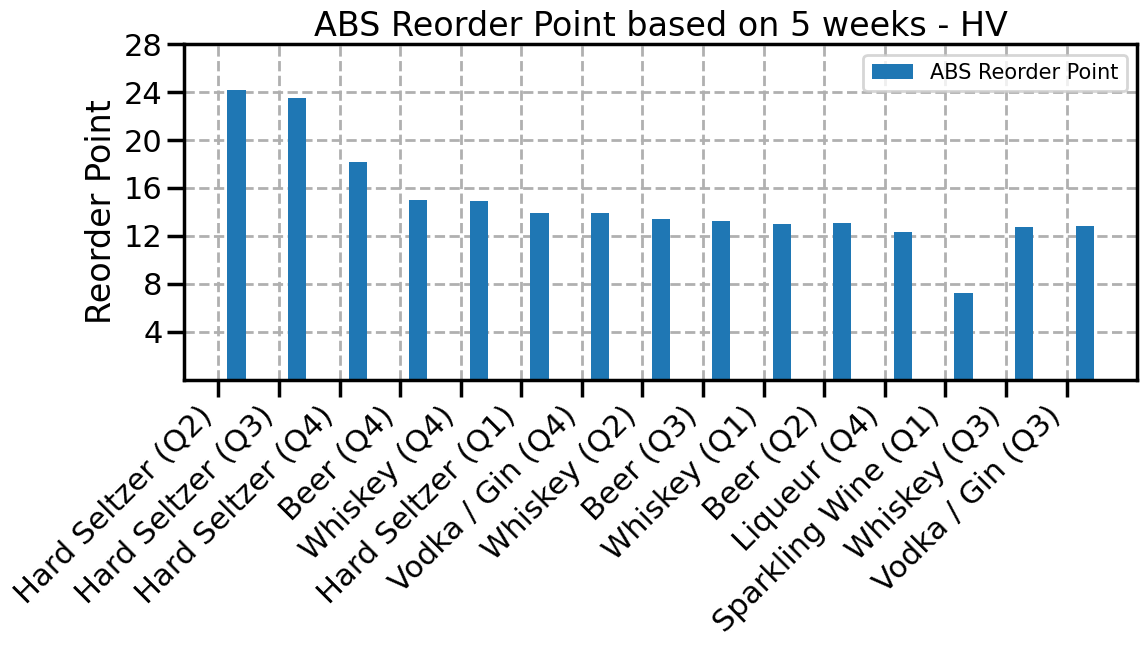

In [257]:
subset = weekly_stats[['Alcohol Type', 'Reorder Point', 'Reorder Point ABS', 'Quarter']].copy()
subset = subset.sort_values('Reorder Point', ascending=False).head(15)

x = range(len(subset))

xtick_labels = [f"{row['Alcohol Type']} ({row['Quarter']})" for _, row in subset.iterrows()]

plt.figure(figsize=(12, 7))
plt.bar([i + 0.4 for i in x], subset['Reorder Point ABS'], width=0.3, label='ABS Reorder Point', align='center')


plt.xticks([i + 0.1 for i in x], xtick_labels, rotation=45, ha='right')
plt.yticks(range(4,30,4))
plt.ylabel('Reorder Point')
plt.title('ABS Reorder Point based on 5 weeks - HV')
plt.legend(fontsize = 15)
plt.tight_layout()
plt.grid(linestyle = "--")
plt.gca().set_axisbelow(True)
plt.show()

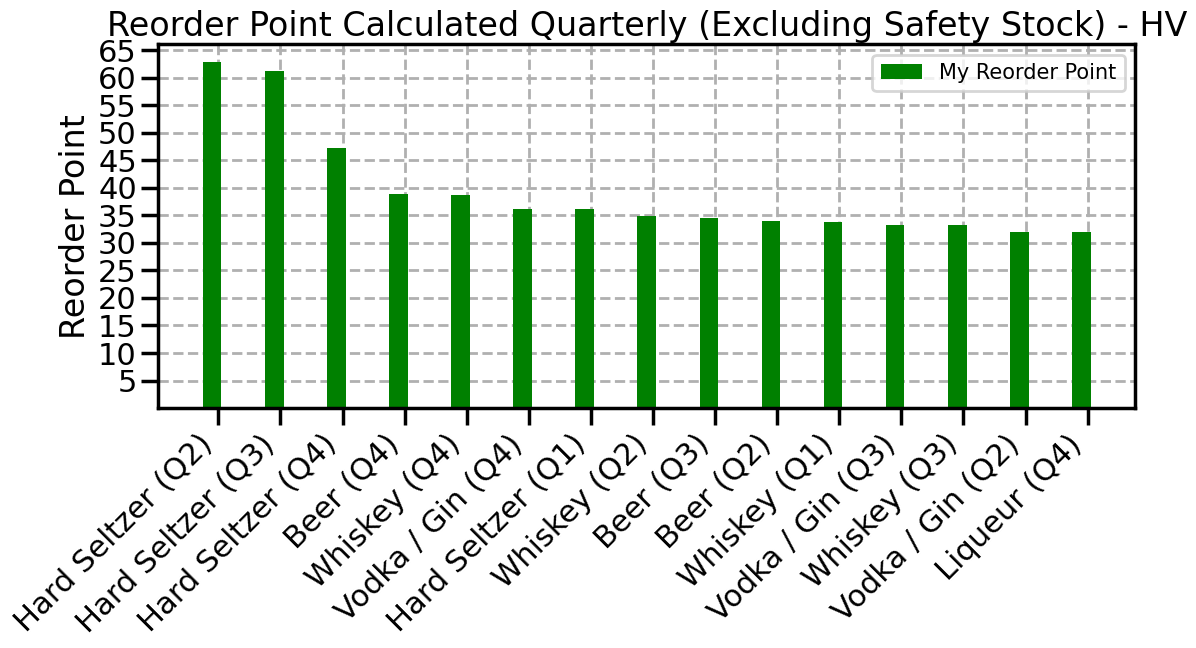

In [258]:
weekly_stats['Reorder Point'] = (
    weekly_stats['Daily Avg'] * weekly_stats['Lead Time'])

subset = weekly_stats[['Alcohol Type', 'Reorder Point', 'Reorder Point ABS', 'Quarter']].copy()
subset = subset.sort_values('Reorder Point', ascending=False).head(15)

x = range(len(subset))

xtick_labels = [f"{row['Alcohol Type']} ({row['Quarter']})" for _, row in subset.iterrows()]

plt.figure(figsize=(12, 7))
plt.bar(x, subset['Reorder Point'], width=0.3, label='My Reorder Point', align='center', color = 'green')


plt.xticks([i + 0.1 for i in x], xtick_labels, rotation=45, ha='right')
plt.yticks(range(5,70,5))
plt.ylabel('Reorder Point')
plt.title('Reorder Point Calculated Quarterly (Excluding Safety Stock) - HV')
plt.legend(fontsize = 15)
plt.tight_layout()
plt.grid(linestyle = "--")
plt.gca().set_axisbelow(True)
plt.show()

#**My Reorder Point Formula Without Safety Stock bar chart**
This bar chart displays the top 15 reorder point values, grouped by quarter and alcohol type, calculated using the formula: daily average sales multiplied by lead time, without factoring in safety stock. The x-axis labels have been formatted with assistance from ChatGPT to include the quarter in parentheses alongside each alcohol type for enhanced readability.

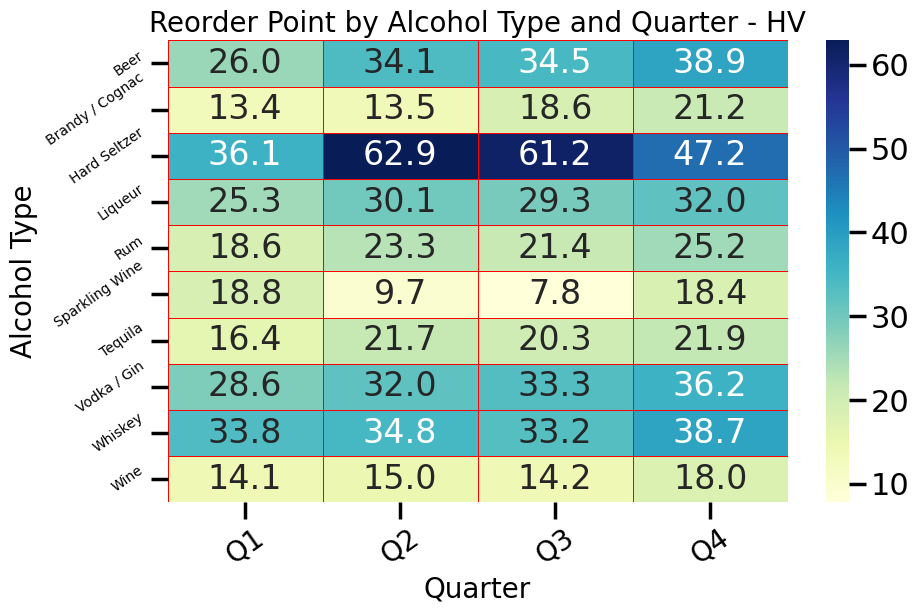

In [259]:
plt.figure(figsize = (10,6))
heatmap_data = weekly_stats.pivot_table(
    index = 'Alcohol Type',
    columns = 'Quarter',
    values = 'Reorder Point'
)

sns.heatmap(heatmap_data, annot = True, cmap = 'YlGnBu', fmt = ".1f", linewidths=.5, linecolor = 'red')

plt.title("Reorder Point by Alcohol Type and Quarter - HV", fontsize=20)
plt.xlabel("Quarter", fontsize=20)
plt.ylabel("Alcohol Type", fontsize=20)
plt.xticks(rotation=35, fontsize=20)
plt.yticks(rotation=35, fontsize=10)
plt.show()

#**Reorder Point Heatmap**
Created a heatmap to visualize the reorder point of each alcohol type by quarter, helping identify top-selling items and highlight significant seasonal demand shifts.

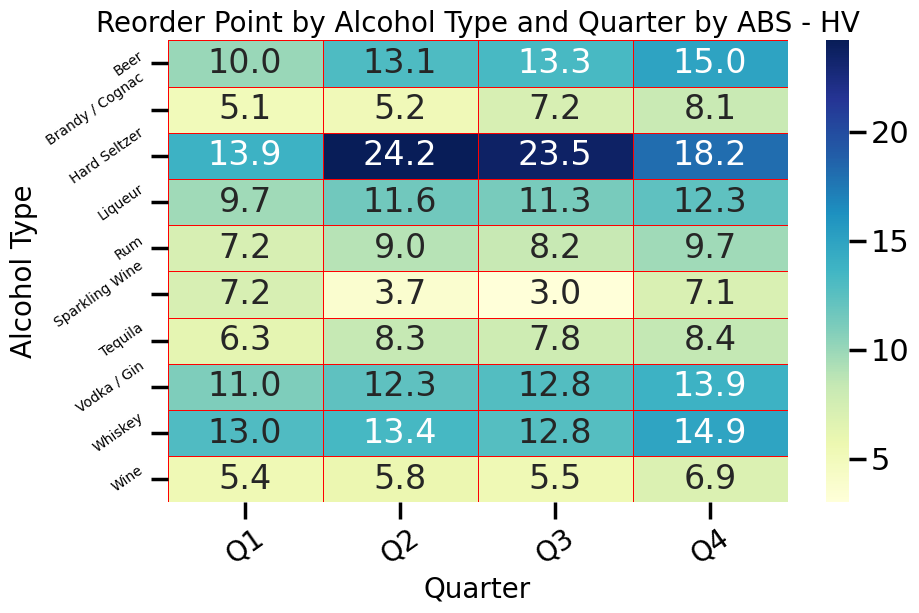

In [260]:
plt.figure(figsize = (10,6))
heatmap_data = weekly_stats.pivot_table(
    index = 'Alcohol Type',
    columns = 'Quarter',
    values = 'Reorder Point ABS'
)

sns.heatmap(heatmap_data, annot = True, cmap = 'YlGnBu', fmt = ".1f", linewidths=.5, linecolor = 'red')

plt.title("Reorder Point by Alcohol Type and Quarter by ABS - HV", fontsize=20)
plt.xlabel("Quarter", fontsize=20)
plt.ylabel("Alcohol Type", fontsize=20)
plt.xticks(rotation=35, fontsize=20)
plt.yticks(rotation=35, fontsize=10)
plt.show()

#**Reorder Point Heatmap ABS**

ABS's quarterly calculations for the top 10 alcohol categories result in significantly lower values compared to my analysis, implying a less frequent order cycle.

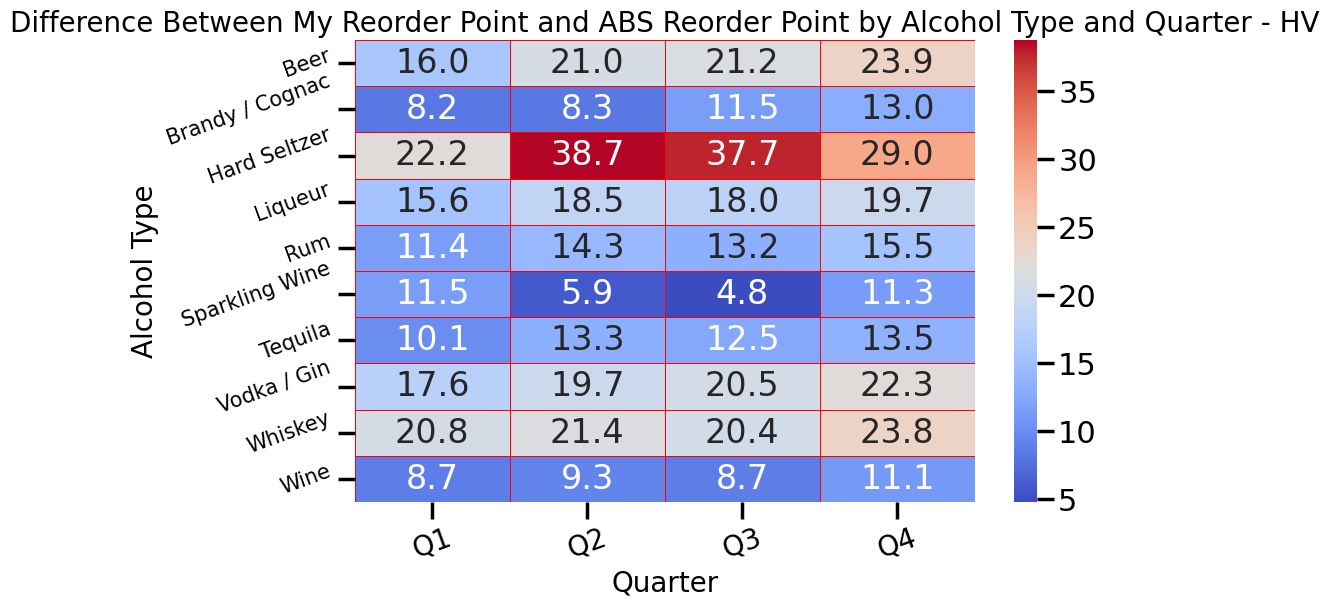

In [261]:
weekly_stats['Reorder Point Difference'] = weekly_stats['Reorder Point'] - weekly_stats['Reorder Point ABS']

heatmap_data_diff = weekly_stats.pivot_table(
    index='Alcohol Type',
    columns='Quarter',
    values='Reorder Point Difference'
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_diff, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5, linecolor='red')

plt.title("Difference Between My Reorder Point and ABS Reorder Point by Alcohol Type and Quarter - HV", fontsize=20)
plt.xlabel("Quarter", fontsize=20)
plt.ylabel("Alcohol Type", fontsize=20)
plt.xticks(rotation=20, fontsize=20)
plt.yticks(rotation=20, fontsize=15)
plt.show()

#**Difference in units between my analysis and ABS's Heatmap**

This heatmap displays the differences between my calculated reorder points and those used by ABS, organized by alcohol type and quarter. Warmer tones indicate where my model suggests higher reorder points, while cooler tones highlight areas where ABS’s values are greater.

As shown in the earlier bar chart, the discrepancy for hard seltzer in Q2 is particularly significant, with my estimate nearly 30 units higher than ABS’s.

Overall, my reorder points are consistently higher across most categories, indicating a more conservative approach that prioritizes maintaining higher inventory levels to buffer against demand fluctuations or potential lead time delays.

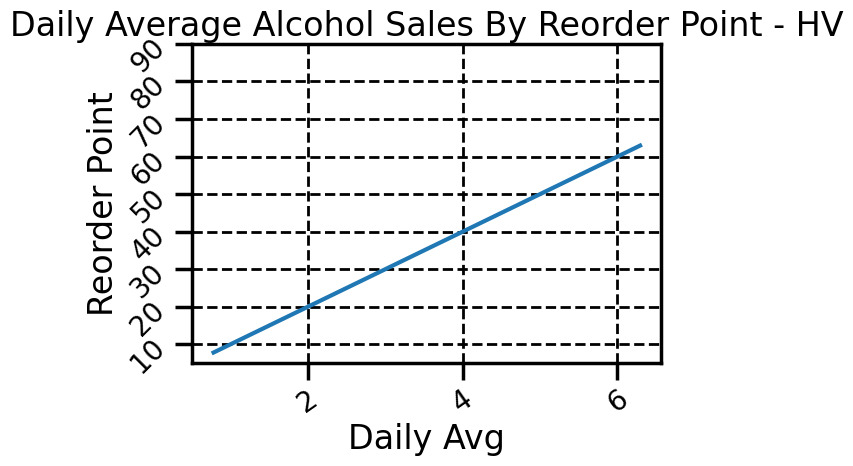

In [262]:
sns.lineplot(x = 'Daily Avg', y = 'Reorder Point', data = weekly_stats)

sns.set_context("poster")
plt.tight_layout()
plt.title("Daily Average Alcohol Sales By Reorder Point - HV")
plt.grid(linestyle = "--", color = "black")
plt.xticks(rotation = 35, fontsize = 20)
plt.yticks(range(10,100,10),rotation = 45, fontsize = 20)
plt.gca().set_axisbelow(True)
plt.show()

#**Daily Average alcohol sales by Reorder Point lineplot**

The line plot above illustrates that as the daily average alcohol sales increase, the corresponding reorder point also rises; which is logical, since higher sales volumes demand more frequent restocking. There is a stark increase in the reorder point when daily avg sales are above 4.

In [263]:
melted_sales_data.columns

Index(['Item ID', 'Description', 'Bottles Per Case', 'Week', 'Quantity Total',
       'Quarter'],
      dtype='object')

In [264]:
weekly_stats.columns

Index(['Quarter', 'Alcohol Type', 'Weekly Avg', 'Weekly Std Dev',
       'median Bottles/Case', 'Std Bottles/Case', 'Lead Time', 'Daily Avg',
       'Reorder Point', 'Reorder Threshold', 'Daily Std Dev', 'Safety Stock',
       'Reorder Point ABS', 'Reorder Point Difference'],
      dtype='object')

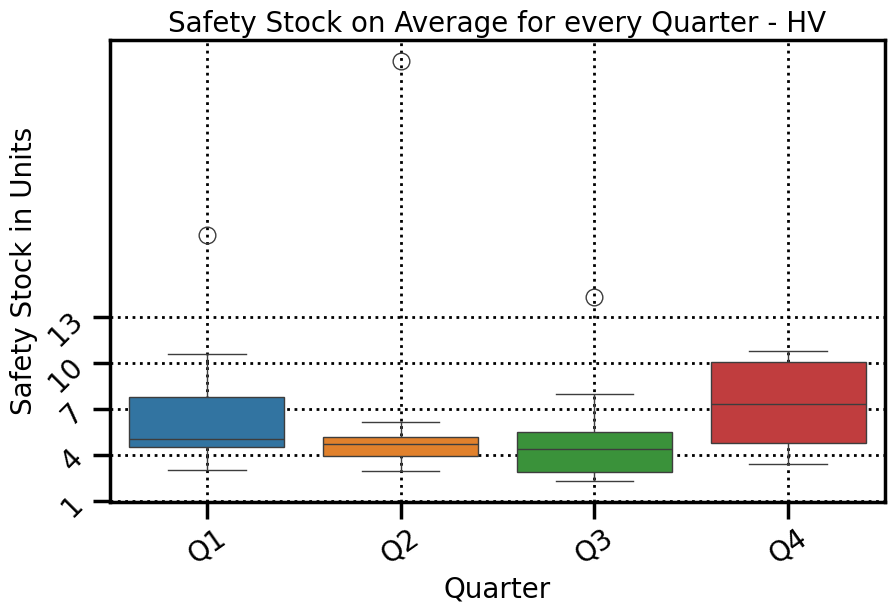

In [265]:
plt.figure(figsize = (10,6))
sns.boxplot(x = "Quarter", y = "Safety Stock", data = weekly_stats, hue = "Quarter")
sns.set_context("poster")
plt.title("Safety Stock on Average for every Quarter - HV", fontsize = 20)
plt.xticks(rotation = 35, fontsize = 20)
plt.yticks(range(1,14,3), rotation = 45, fontsize = 20)
plt.xlabel("Quarter", fontsize = 20)
plt.ylabel("Safety Stock in Units", fontsize = 20)
plt.grid(linestyle = ":", color = "black")
plt.show()

#**Safety Stock by quarter Boxplot**
Created a boxplot displaying safety stock by quarter. For example, in Q4, there's more variation in the amount of alcohol needed, indicating greater week-to-week sales fluctuations during this period.

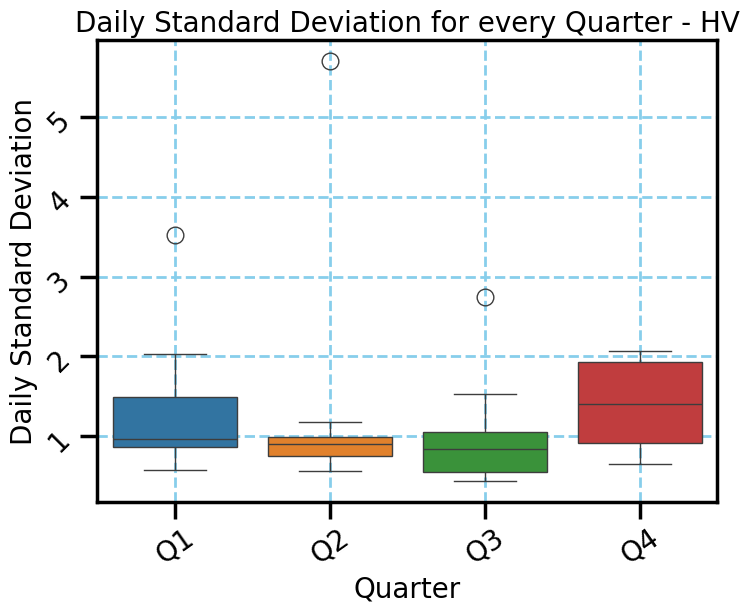

In [266]:
plt.figure(figsize = (8,6))
sns.boxplot(x = "Quarter", y = "Daily Std Dev", hue = "Quarter", data = weekly_stats)
plt.title("Daily Standard Deviation for every Quarter - HV", fontsize = 20)
plt.yticks(rotation = 45, fontsize = 20)
plt.xticks(rotation = 35, fontsize = 20)
plt.xlabel("Quarter", fontsize = 20)
plt.ylabel("Daily Standard Deviation", fontsize = 20)
plt.grid(linestyle = "dashed", color = "skyblue")
plt.show()

#**Daily Standard Deviation by Quarter Boxplot**
Generated a boxplot to visualize the daily standard deviation of sales by quarter. As with earlier charts, Q4 displays the highest variability, suggesting increased week-to-week fluctuations and stronger seasonal shifts during this period.

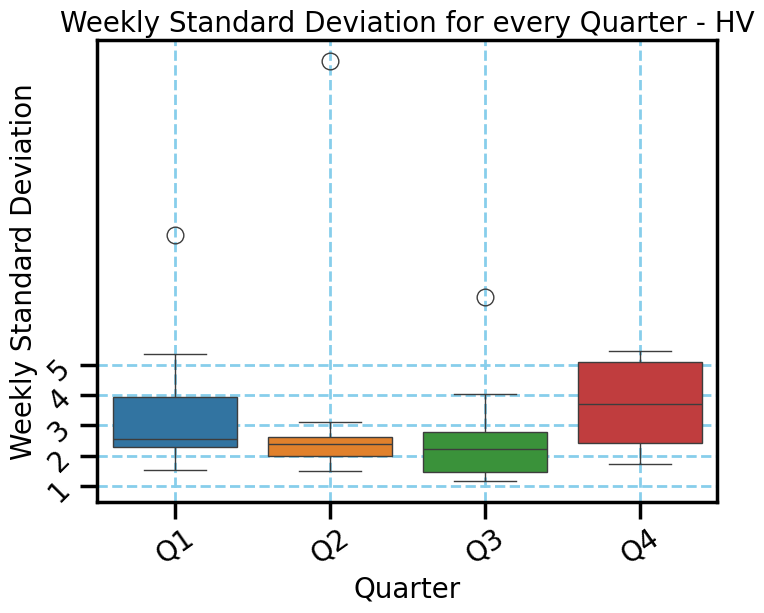

In [267]:
plt.figure(figsize = (8,6))
sns.boxplot(x = "Quarter", y = "Weekly Std Dev", hue = "Quarter", data = weekly_stats)
plt.title("Weekly Standard Deviation for every Quarter - HV", fontsize = 20)
plt.yticks(range(1,6,1),rotation = 45, fontsize = 20)
plt.xticks(rotation = 35, fontsize = 20)
plt.xlabel("Quarter", fontsize = 20)
plt.ylabel("Weekly Standard Deviation", fontsize = 20)
plt.grid(linestyle = "dashed", color = "skyblue")
plt.show()

#**Weekly Standard Deviation by Quarter Boxplot**
Produced a boxplot to display the weekly standard deviation of sales by quarter. Like the previous visualization, Q4 reveals the highest variability, highlighting significant seasonal fluctuations and more unpredictable demand patterns during that period.

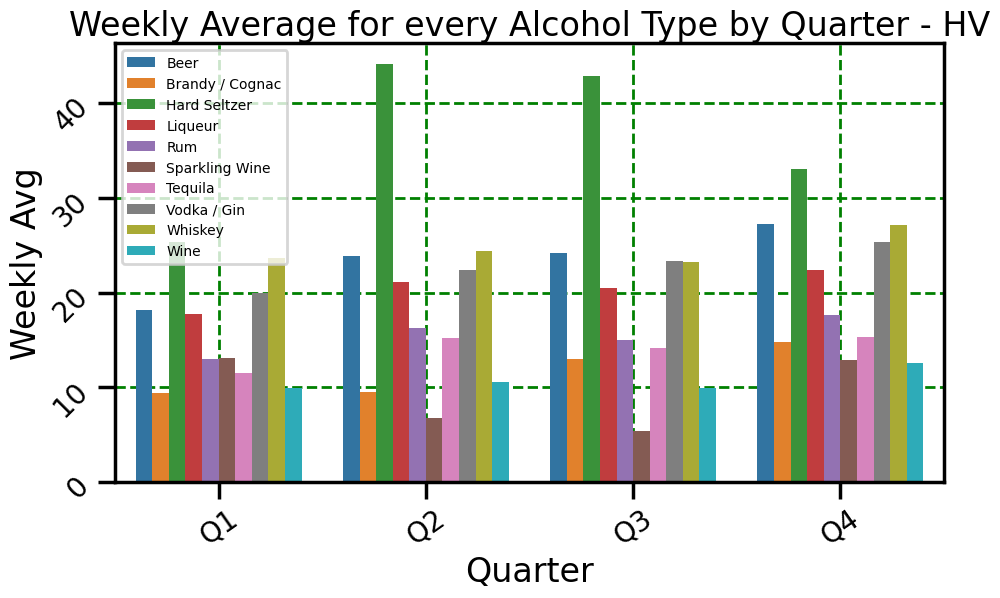

In [268]:
plt.figure(figsize = (10,6))
sns.barplot(x = 'Quarter', y = 'Weekly Avg', data = weekly_stats, hue = 'Alcohol Type' )
sns.set_context("poster")
plt.tight_layout()
plt.legend(loc = 'upper left', fontsize = 10)
plt.title("Weekly Average for every Alcohol Type by Quarter - HV")
plt.grid(linestyle = "--", color = "green")
plt.xticks(rotation = 35, fontsize = 20)
plt.yticks( rotation = 45, fontsize = 20)
plt.gca().set_axisbelow(True)
plt.show()

#**Weekly Average Alcohol Sales by Quarter Bar Chart**
Developed a bar chart to display the weekly average sales for the top 10 alcohol types across each quarter. This visualization helps identify which alcohol categories are most consistently in demand throughout the year. It reveals key seasonal trends—such as increased demand for certain beverages in warmer months (e.g. hard seltzers in Q2/Q3)

This chart can be used to inform purchasing decisions by aligning order volumes with expected seasonal shifts. For instance, items with rising trends in Q3 might require higher safety stock or earlier reordering to avoid stockouts, while items with declining sales can have reduced shelf stock to limit excess inventory. This directly supports ABS's goal of maintaining optimal stock levels while minimizing overstock of slow-moving products.

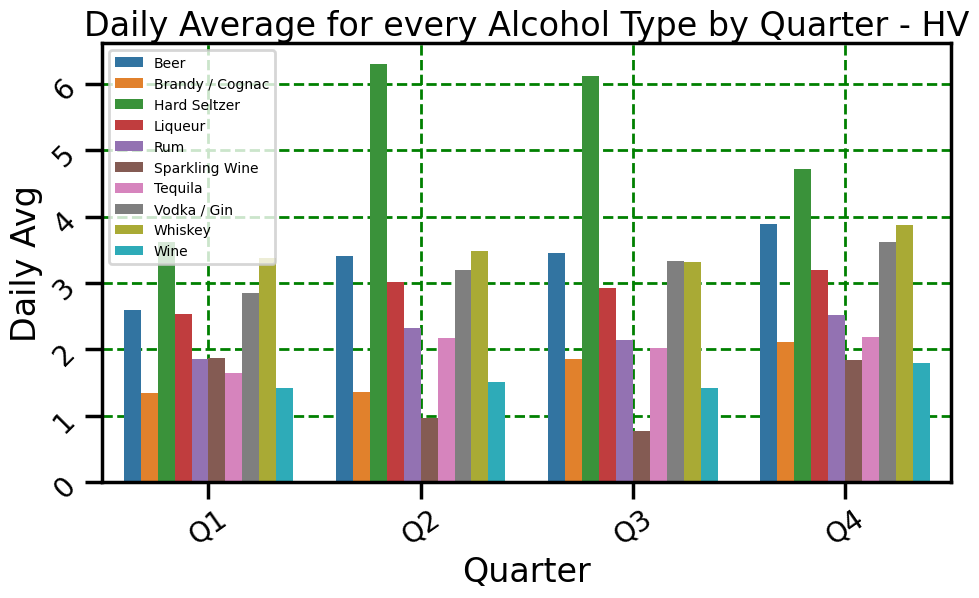

In [269]:
plt.figure(figsize = (10,6))
sns.barplot(x = 'Quarter', y = 'Daily Avg', data = weekly_stats, hue = 'Alcohol Type' )
sns.set_context("poster")
plt.tight_layout()
plt.legend(loc = 'upper left', fontsize = 10)
plt.title("Daily Average for every Alcohol Type by Quarter - HV")
plt.grid(linestyle = "--", color = "green")
plt.xticks(rotation = 35, fontsize = 20)
plt.yticks( rotation = 45, fontsize = 20)
plt.gca().set_axisbelow(True)
plt.show()

#**Daily Average Alcohol Sales by Quarter Bar Chart**
This bar chart shows the daily average sales for the top 10 alcohol types across all four quarters. It highlights which types of alcohol are consistently popular and which ones experience seasonal spikes in demand. This information is useful for determining which items may require higher safety stock in certain quarters to prevent stockouts and ensure shelves remain stocked with high-demand products.

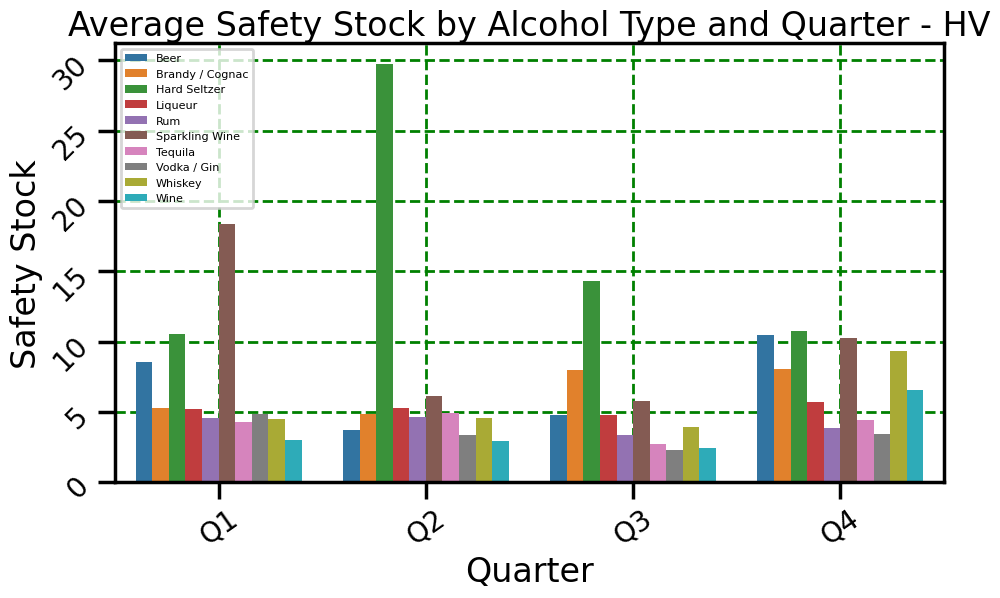

In [270]:
plt.figure(figsize = (10,6))
sns.barplot(x = 'Quarter', y = 'Safety Stock', data = weekly_stats, hue = 'Alcohol Type' )
sns.set_context("poster")
plt.tight_layout()
plt.legend(loc = 'upper left', fontsize = 8)
plt.title("Average Safety Stock by Alcohol Type and Quarter - HV")
plt.grid(linestyle = "--", color = "green")
plt.xticks(rotation = 35, fontsize = 20)
plt.yticks(rotation = 45, fontsize = 20)
plt.gca().set_axisbelow(True)
plt.show()

# **Average Safety Stock by Alcohol Type and Quarter Bar Chart**

This chart displays the average safety stock required for each alcohol type across different quarters. It helps identify which alcohol types may need higher inventory levels during specific quarters based on their seasonal demand patterns, with variations clearly highlighted by the seasonal shifts

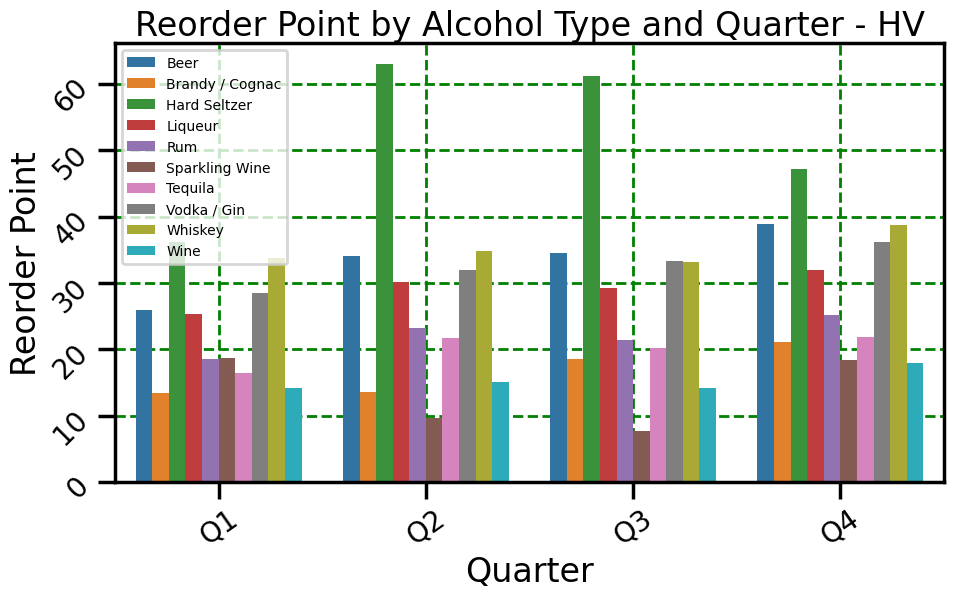

In [271]:
plt.figure(figsize = (10,6))
sns.barplot(x = 'Quarter', y = 'Reorder Point', data = weekly_stats, hue = 'Alcohol Type' )
sns.set_context("poster")
plt.tight_layout()
plt.legend(loc = 'upper left', fontsize = 10)
plt.title("Reorder Point by Alcohol Type and Quarter - HV")
plt.grid(linestyle = "--", color = "green")
plt.xticks(rotation = 35, fontsize = 20)
plt.yticks( rotation = 45, fontsize = 20)
plt.gca().set_axisbelow(True)
plt.show()

# **Reorder Point by Alcohol Type and Quarter Bar Chart**

This chart visualizes the reorder point for each alcohol type across different quarters. It shows the point at which inventory levels should trigger a restock, helping to determine the ideal order quantities for each alcohol type based on quarterly demand fluctuations.